# Notebook Overview

In this notebook, I'm testing several different notebooks to guess the customer satisfaction at restaurants as 1 being highly satisfied or 0 as being not satisfied. The models I test are:

* Random Forest Classifier (accuracy: 0.88)
* Gradient Boosting Classifier (accuracy: 0.91)
* Light GBM Classifier (accuracy: 0.88)
* XGB Classifier (accuracy: 0.88)
* Cat Boost Classifier (accuracy: 0.89)

Also applied data visualizations, feature engineering and correlation analysis.

# Dataset

* CustomerID (text)
* Age (numeric)
* Gender (text: male/female)
* Income (numeric, in USD)
* VisitFrequency (text: Daily/Monthly/Rarely/Weekly)
* AverageSpend (numeric, in USD)
* PreferredCuisine (text: Italian/Chinese/Indian/Mexican/American)
* TimeOfVisit (text: Breakfast/Lunch/Dinner)
* GroupSize (numeric)
* DiningOccasion (text: Casual/Business/Celebration)
* MealType (text: Dine-in/Takeaway)
* OnlineReservation (numeric: 0:No/1:Yes)
* DeliveryOrder: (numeric: 0:No/1:Yes)
* LoyaltyProgramMember: (numeric: 0:No/1:Yes)
* WaitTime: (numeric, in minutes)
* ServiceRating: (numeric, from 1 to 5)
* FoodRating: (numeric, from 1 to 5)
* AmbianceRating: (numeric, from 1 to 5)
* High Satisfaction: (target: 0:Not highly satisfied/1:Highly satisfied)

# Importing Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

pd.set_option('display.width', 1000)
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn.categorical")

# Reading the Dataset

In [2]:
df = pd.read_csv("/kaggle/input/predict-restaurant-customer-satisfaction-dataset/restaurant_customer_satisfaction.csv")
df.head()

,CustomerID,Age,Gender,Income,VisitFrequency,AverageSpend,PreferredCuisine,TimeOfVisit,GroupSize,DiningOccasion,MealType,OnlineReservation,DeliveryOrder,LoyaltyProgramMember,WaitTime,ServiceRating,FoodRating,AmbianceRating,HighSatisfaction
0,654,35,Male,83380,Weekly,27.829142,Chinese,Breakfast,3,Business,Takeaway,0,1,1,43.523929,2,5,4,0
1,655,19,Male,43623,Rarely,115.408622,American,Dinner,1,Casual,Dine-in,0,0,0,57.524294,5,5,3,0
2,656,41,Female,83737,Weekly,106.693771,American,Dinner,6,Celebration,Dine-in,0,1,0,48.682623,3,4,5,0
3,657,43,Male,96768,Rarely,43.508508,Indian,Lunch,1,Celebration,Dine-in,0,0,0,7.552993,4,5,1,0
4,658,55,Female,67937,Monthly,148.084627,Chinese,Breakfast,1,Business,Takeaway,0,0,1,37.789041,2,3,5,0


# Data Analysis

In [3]:
print("INFORMATION:")
print(df.info())
print("------------------------------------------------")
print("MISSING VALUES:")
print(df.isnull().sum())
print("------------------------------------------------")
print("DATA DESCRIPTION:")
print(df.describe().T)
print("------------------------------------------------")
print("DUPLICATE ROWS:")
print('Duplicate row sayısı:', len(df[df.duplicated()]))

INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CustomerID            1500 non-null   int64  
 1   Age                   1500 non-null   int64  
 2   Gender                1500 non-null   object 
 3   Income                1500 non-null   int64  
 4   VisitFrequency        1500 non-null   object 
 5   AverageSpend          1500 non-null   float64
 6   PreferredCuisine      1500 non-null   object 
 7   TimeOfVisit           1500 non-null   object 
 8   GroupSize             1500 non-null   int64  
 9   DiningOccasion        1500 non-null   object 
 10  MealType              1500 non-null   object 
 11  OnlineReservation     1500 non-null   int64  
 12  DeliveryOrder         1500 non-null   int64  
 13  LoyaltyProgramMember  1500 non-null   int64  
 14  WaitTime              1500 non-null   float64
 15  ServiceR

In [4]:
def unique(data, col):
    return data[col].nunique()

print("Number of Unique Values:")
print("------------------------------")
print(unique(df, df.columns))   

Number of Unique Values:
------------------------------
CustomerID              1500
Age                       52
Gender                     2
Income                  1486
VisitFrequency             4
AverageSpend            1500
PreferredCuisine           5
TimeOfVisit                3
GroupSize                  9
DiningOccasion             3
MealType                   2
OnlineReservation          2
DeliveryOrder              2
LoyaltyProgramMember       2
WaitTime                1500
ServiceRating              5
FoodRating                 5
AmbianceRating             5
HighSatisfaction           2
dtype: int64


In [5]:
df = df.drop('CustomerID', axis=1)

# Variable Types

In [6]:
df['Gender']=df.Gender.astype('category')
df['VisitFrequency']=df.VisitFrequency.astype('category')
df['PreferredCuisine']=df.PreferredCuisine.astype('category')
df['TimeOfVisit']=df.TimeOfVisit.astype('category')
df['DiningOccasion']=df.DiningOccasion.astype('category')
df['MealType']=df.MealType.astype('category')
df['DiningOccasion']=df.DiningOccasion.astype('category')

for col in df.columns:
    if df[col].dtype != 'category':
        df[col] = df[col].astype(float)

In [7]:
cat_columns = []
num_columns = []
bin_columns = []

def binary(col):
    return col.isin([0.0, 1.0]).all()

for col in df.columns:
    if df[col].dtype == 'category':
        cat_columns.append(col)
    elif binary(df[col]):
        bin_columns.append(col) 
    else:
        num_columns.append(col)

print(f'Categorical Variables: {cat_columns}')
print("------------------------------------------------------------------------")
print(f'Numerical Variables: {num_columns}')
print("------------------------------------------------------------------------")
print(f'Binary Variables: {bin_columns}')

Categorical Variables: ['Gender', 'VisitFrequency', 'PreferredCuisine', 'TimeOfVisit', 'DiningOccasion', 'MealType']
------------------------------------------------------------------------
Numerical Variables: ['Age', 'Income', 'AverageSpend', 'GroupSize', 'WaitTime', 'ServiceRating', 'FoodRating', 'AmbianceRating']
------------------------------------------------------------------------
Binary Variables: ['OnlineReservation', 'DeliveryOrder', 'LoyaltyProgramMember', 'HighSatisfaction']


# Checking for Outliers and Dealing with Them

In [8]:
df_numeric = df[num_columns]

def outliers_detection(data, col_name, q1=0.05, q3=0.95):
    Q1 = data[col_name].quantile(q1)
    Q3 = data[col_name].quantile(q3)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[col_name] < lower) | (data[col_name] > upper)]
    return outliers

def replacing_outliers(data, col_name, q1=0.05, q3=0.95):
    Q1 = data[col_name].quantile(q1)
    Q3 = data[col_name].quantile(q3)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data.loc[data[col_name] < lower, col_name] = Q1
    data.loc[data[col_name] > upper, col_name] = Q3
    return Q1, Q3

for col in df_numeric.columns:
    outliers = outliers_detection(df_numeric, col)
    if not outliers.empty:
        print(f"In column {col} total number of outliers: {len(outliers)}")
        print(f"Outliers in the column {col}:")
        print(outliers)
        Q1, Q3 = replacing_outliers(df_numeric, col)
        print(f"In {col} column higher outliers are replaced with {Q3}:")
        print(f"In {col} column lower outliers are replaced with {Q1}:")
        print("------------------------------------------------------------------------")
    else:
        print(f"There are no outliers in column {col}.")
        print("------------------------------------------------------------------------")

There are no outliers in column Age.
------------------------------------------------------------------------
There are no outliers in column Income.
------------------------------------------------------------------------
There are no outliers in column AverageSpend.
------------------------------------------------------------------------
There are no outliers in column GroupSize.
------------------------------------------------------------------------
There are no outliers in column WaitTime.
------------------------------------------------------------------------
There are no outliers in column ServiceRating.
------------------------------------------------------------------------
There are no outliers in column FoodRating.
------------------------------------------------------------------------
There are no outliers in column AmbianceRating.
------------------------------------------------------------------------


# Analysis of the Target Variable

In [9]:
df["HighSatisfaction"].value_counts()

HighSatisfaction
0.0    1299
1.0     201
Name: count, dtype: int64

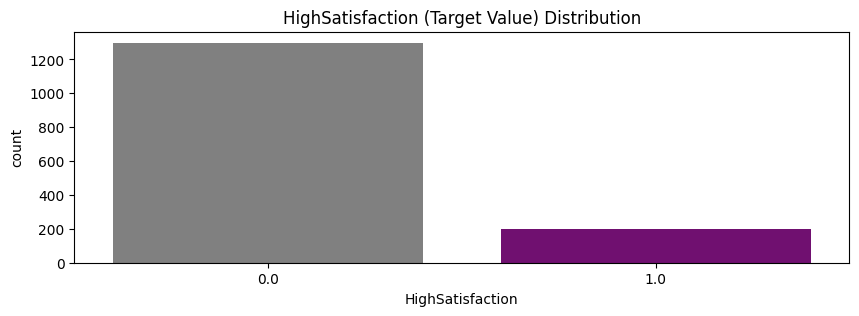

In [10]:
plt.figure(figsize=(10, 3))
sns.countplot(x ='HighSatisfaction', data = df, palette=['gray', 'purple'])
plt.title('HighSatisfaction (Target Value) Distribution')
 
plt.show()

# Visualization of Categorical and Binary Variables

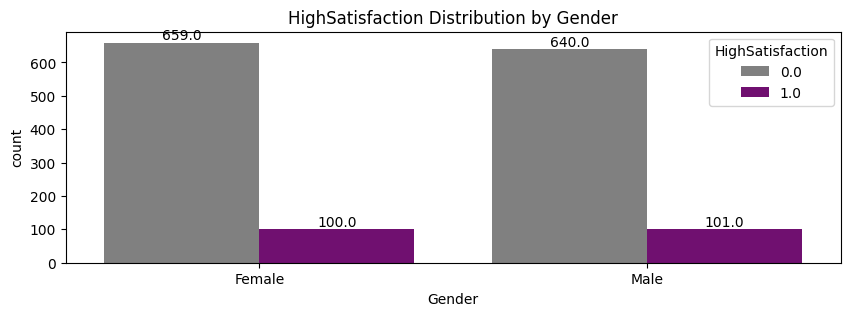

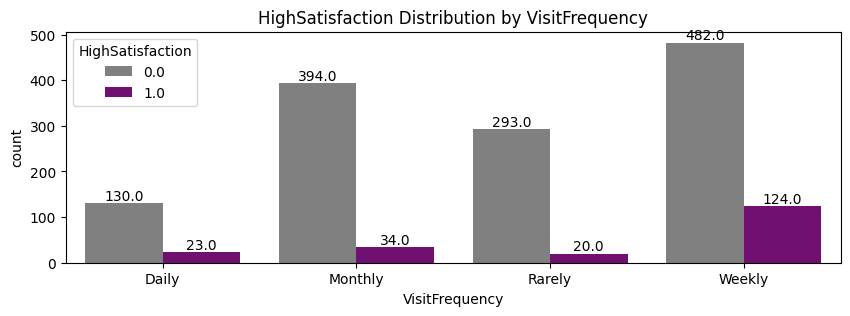

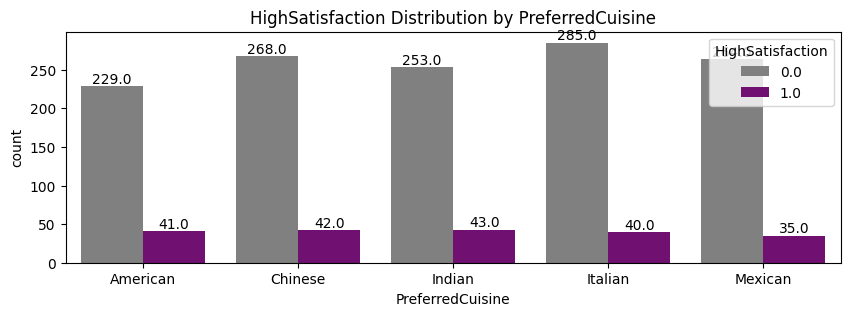

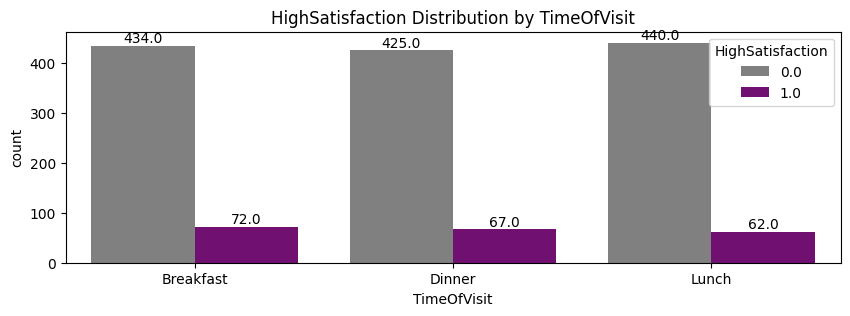

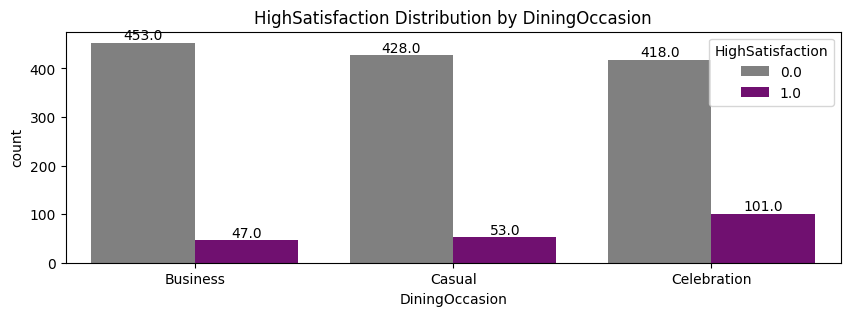

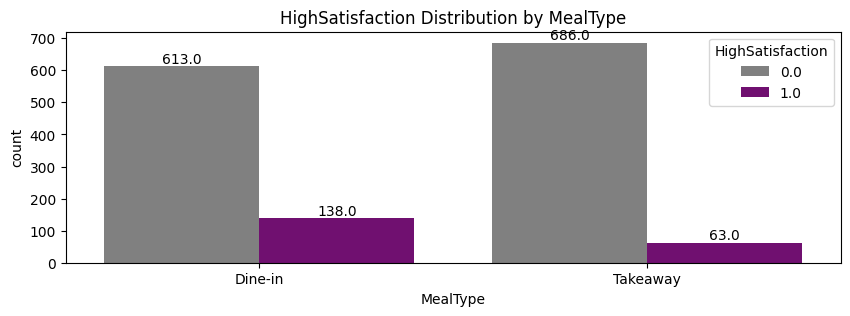

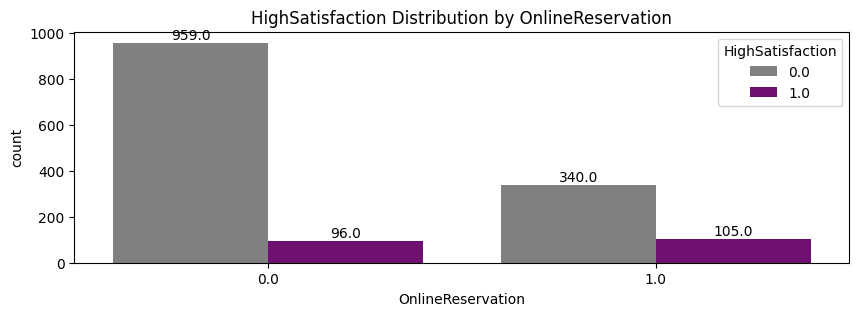

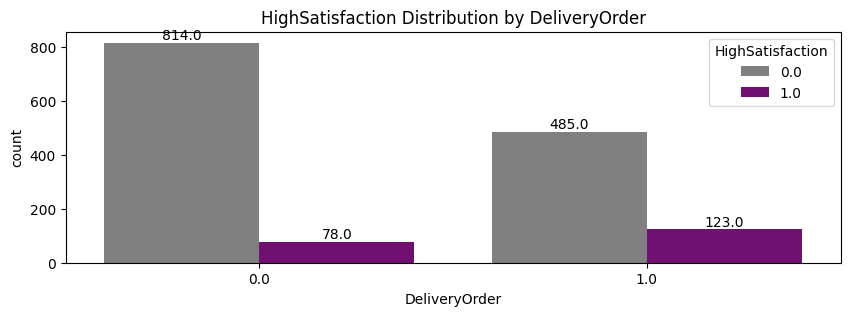

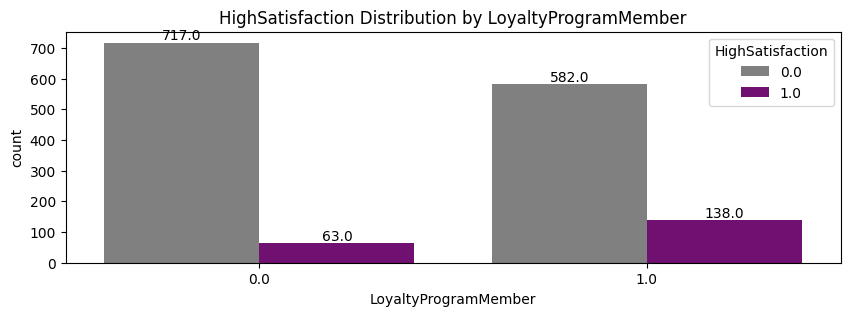

In [11]:
def plot_cat_bin_count(df, cat_var, figsize=(10, 3), palette=['gray', 'purple']):
    plt.figure(figsize=figsize)
    ax = sns.countplot(x=cat_var, hue='HighSatisfaction', data=df, palette=palette)
    plt.title(f'HighSatisfaction Distribution by {cat_var}')
    
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='center', 
                    xytext=(0, 5), 
                    textcoords='offset points')
    
    plt.show()
    
vis_bin_columns = [col for col in bin_columns if col != 'HighSatisfaction']
 
for col in cat_columns:    
    plot_cat_bin_count(df, col)
    
for col in vis_bin_columns:    
    plot_cat_bin_count(df, col)

# Visualization of Numerical Variables

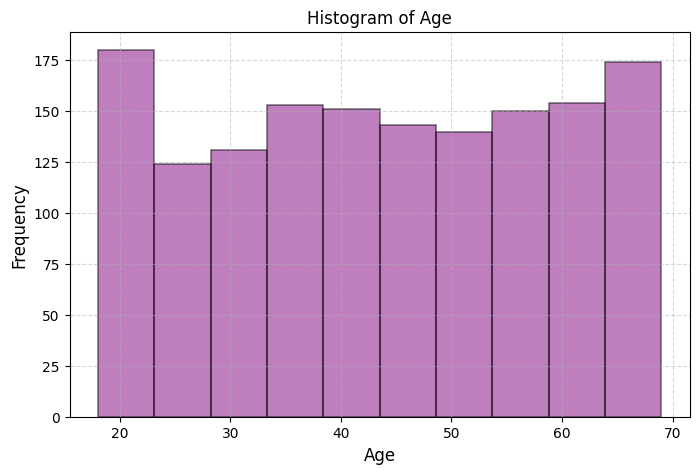

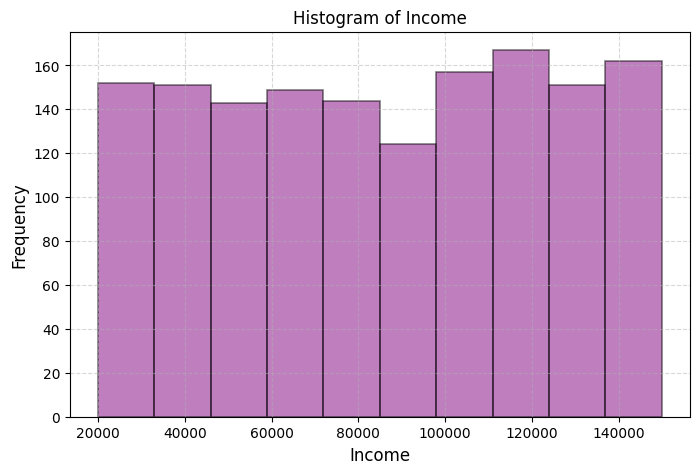

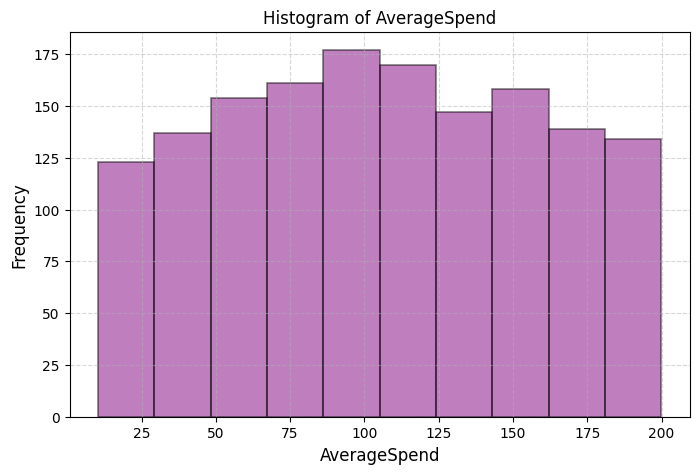

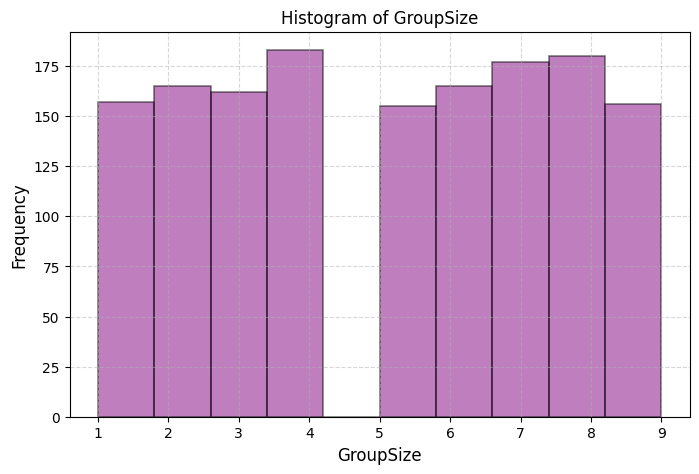

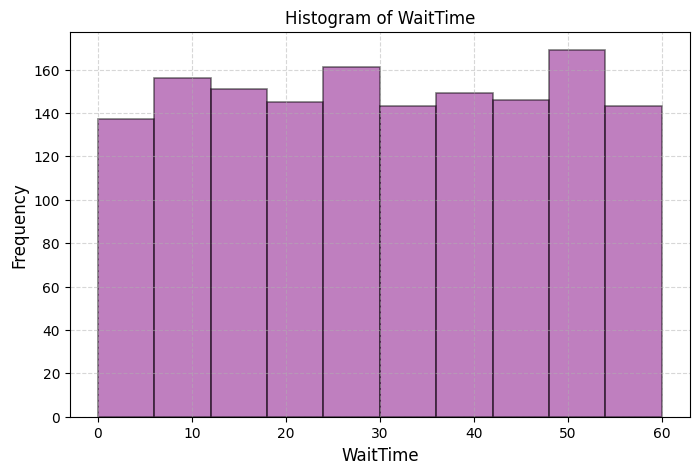

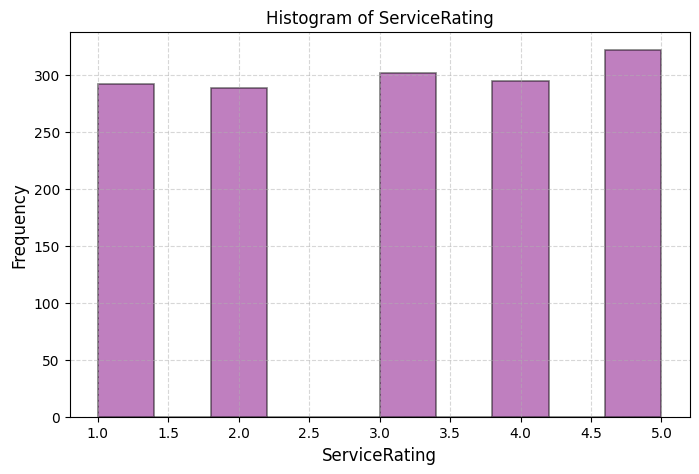

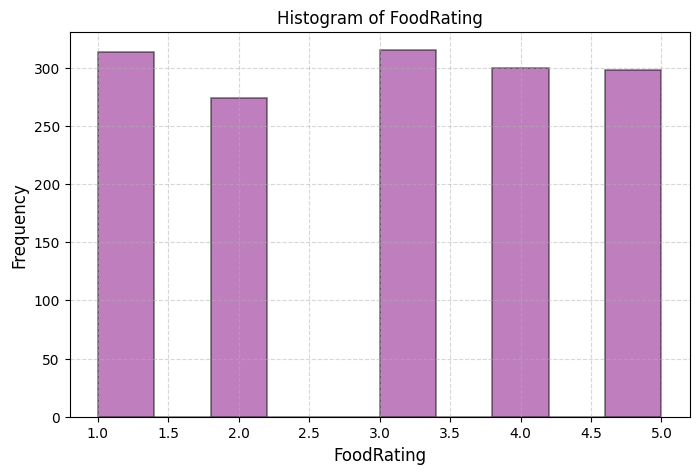

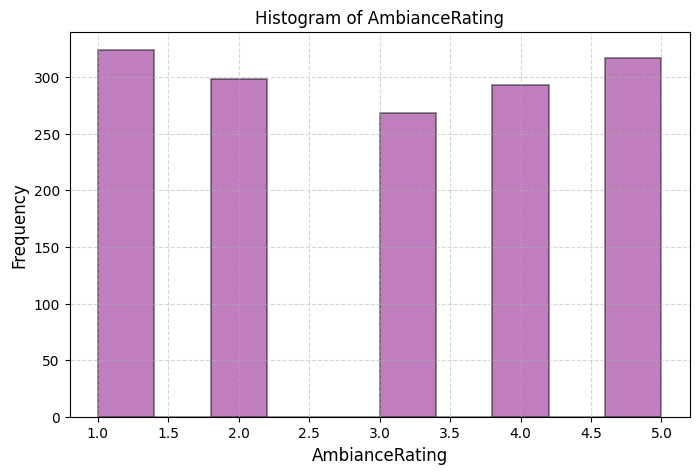

In [12]:
def vis_nums(data, numeric_cols):
    for col in numeric_cols:
        fig, ax = plt.subplots(figsize=(8, 5))
        data[col].plot.hist(alpha=0.5, color='purple', edgecolor='black', linewidth=1.2, ax=ax)
        
        ax.grid(True, linestyle='--', alpha=0.5)
        
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title(f'Histogram of {col}', fontsize=12)
        
        plt.show()

vis_nums(df, num_columns)

# Feature Engineering

Adding three new features to increase the model accuracy:
* Income per AverageSpend
* AverageSpend per GroupSize (good for showing the expensiveness of the restaurant)
* Income per GroupSize

In [13]:
df['Income_per_AverageSpend'] = df['Income'] / df['AverageSpend']
df['AverageSpend_per_GroupSize'] = df['AverageSpend'] / df['GroupSize']
df['Income_per_GroupSize'] = df['Income'] / df['GroupSize']

# Encoding

Label encoding the features where there are two variables and assessing dummy variables to other categorical data

In [14]:
columns_to_dummy = ['VisitFrequency', 'PreferredCuisine', 'TimeOfVisit', 'DiningOccasion']
columns_to_encode = ['Gender', 'MealType']
df = pd.get_dummies(df, columns=columns_to_dummy, dtype=int, drop_first=True)
labelencoder = LabelEncoder()
    
for col in columns_to_encode:
    df[col] = labelencoder.fit_transform(df[col])

df.head()

,Age,Gender,Income,AverageSpend,GroupSize,MealType,OnlineReservation,DeliveryOrder,LoyaltyProgramMember,WaitTime,...,VisitFrequency_Rarely,VisitFrequency_Weekly,PreferredCuisine_Chinese,PreferredCuisine_Indian,PreferredCuisine_Italian,PreferredCuisine_Mexican,TimeOfVisit_Dinner,TimeOfVisit_Lunch,DiningOccasion_Casual,DiningOccasion_Celebration
0,35.0,1,83380.0,27.829142,3.0,1,0.0,1.0,1.0,43.523929,...,0,1,1,0,0,0,0,0,0,0
1,19.0,1,43623.0,115.408622,1.0,0,0.0,0.0,0.0,57.524294,...,1,0,0,0,0,0,1,0,1,0
2,41.0,0,83737.0,106.693771,6.0,0,0.0,1.0,0.0,48.682623,...,0,1,0,0,0,0,1,0,0,1
3,43.0,1,96768.0,43.508508,1.0,0,0.0,0.0,0.0,7.552993,...,1,0,0,1,0,0,0,1,0,1
4,55.0,0,67937.0,148.084627,1.0,1,0.0,0.0,1.0,37.789041,...,0,0,1,0,0,0,0,0,0,0


# Correlation Analysis

Creating a heatmap to see the correlations between different variables

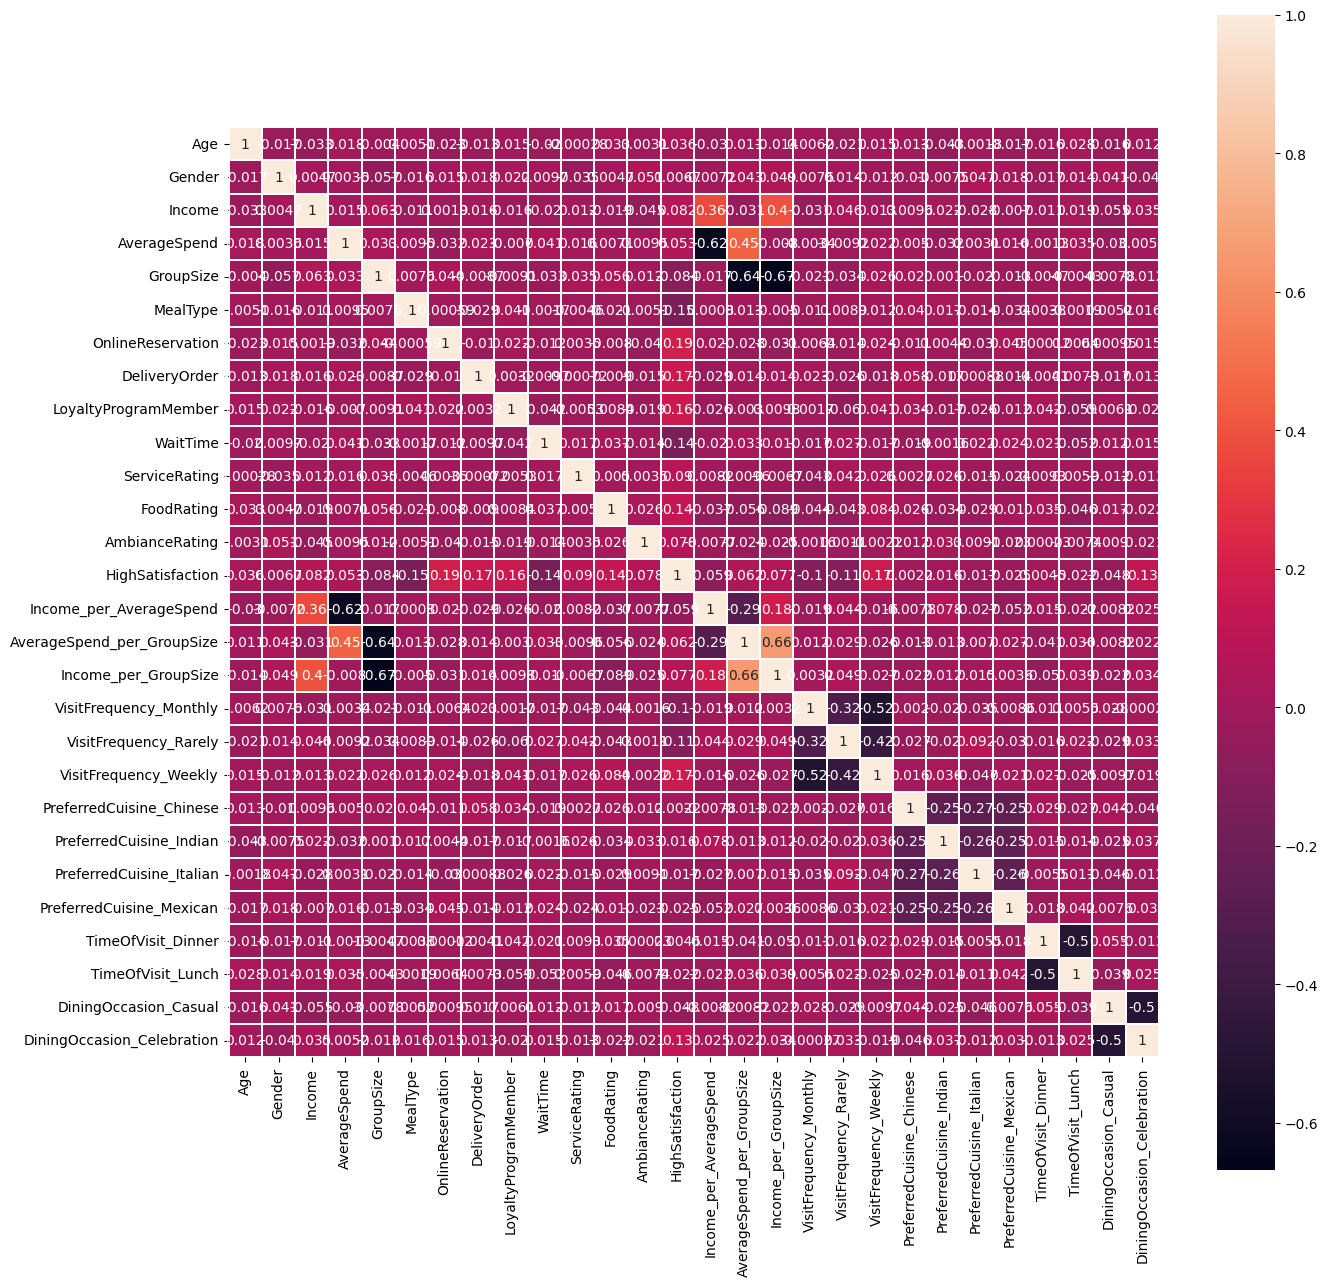

In [15]:
plt.figure(figsize=(15,15))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

# ML Models

Applying standard scaler and spliting the data into x and y and train and test sets

In [16]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df[num_columns])
df[num_columns] = pd.DataFrame(x_scaled, columns=num_columns)

x = df.drop('HighSatisfaction', axis=1)
y = df['HighSatisfaction']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Defining the function to run the models and assess their accuracy including the following metrics:
* ROC_AUC (Area Under the Curve): The ability to distinguish between classes
* Precision: Number of correctly predicted ones that turn out to be positive
* Recall (Sensitivity): Number of positive ones that were predicted correctly
* F1: Combination of precision and recall
* Accuracy: Frequency of the correct predictions of the model

Also plotting a confusion matrix which shows the number of true positives, true negatives, false positives and false negatives.

In [17]:
def model_run_assess(model, x_train, y_train, x_test, y_test, verbose=True):
    model.fit(x_train,y_train)
    y_prediction = model.predict(x_test)
    roc_auc = roc_auc_score(y_test, y_prediction)
    print("ROC_AUC = {}".format(roc_auc))
    print("--------------------------------------------------")
    
    print(classification_report(y_test,y_prediction,digits=5))
    print("--------------------------------------------------")
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_prediction)
    plt.figure(figsize=(1, 1))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
    cm_display.plot(cmap=plt.cm.Purples)
    plt.show()
    print("--------------------------------------------------")
    
    print("Accuracy:", accuracy_score(y_test, y_prediction))
    
    return model, roc_auc

Starting with a random forest classifier the accuracy is good but the ROC_AUC can be increased. Also the recall and f1-scores are very very low.

ROC_AUC = 0.5487804878048781
--------------------------------------------------
              precision    recall  f1-score   support

         0.0    0.87500   1.00000   0.93333       259
         1.0    1.00000   0.09756   0.17778        41

    accuracy                        0.87667       300
   macro avg    0.93750   0.54878   0.55556       300
weighted avg    0.89208   0.87667   0.83007       300

--------------------------------------------------


<Figure size 100x100 with 0 Axes>

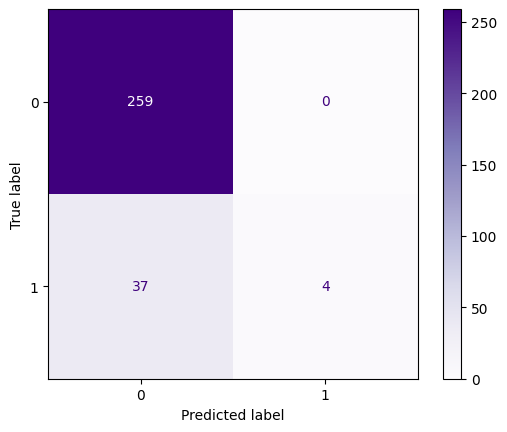

--------------------------------------------------
Accuracy: 0.8766666666666667


In [18]:
params_rf = {'max_depth': 50,
         'min_samples_leaf': 1,
         'min_samples_split': 2,
         'n_estimators': 1200,
         'random_state': 42}

model_rf = RandomForestClassifier(**params_rf)
model_rf, roc_auc_rf = model_run_assess(model_rf, x_train, y_train, x_test, y_test)

Moving on with a Gradient Boosting Classifier the ROC_AUC increased significantly. Also the recall and the F1 both increased. The accuracy is also very nice. However the recall and F1 can still increase.

ROC_AUC = 0.7015255673792259
--------------------------------------------------
              precision    recall  f1-score   support

         0.0    0.91429   0.98842   0.94991       259
         1.0    0.85000   0.41463   0.55738        41

    accuracy                        0.91000       300
   macro avg    0.88214   0.70153   0.75364       300
weighted avg    0.90550   0.91000   0.89626       300

--------------------------------------------------


<Figure size 100x100 with 0 Axes>

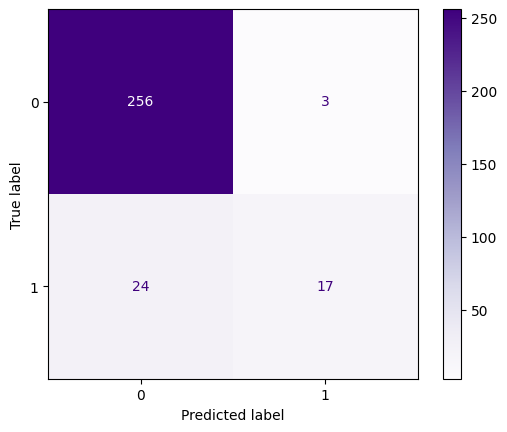

--------------------------------------------------
Accuracy: 0.91


In [19]:
model_gbc=GradientBoostingClassifier(n_estimators=500,learning_rate=0.05,random_state=42,max_features=5 )
model_gbc, roc_auc_gbc = model_run_assess(model_gbc, x_train, y_train, x_test, y_test)

Now onto a Light GBM Classifier. The accuracy, the ROC_AUC and recall and F1 are all less than GBC.

[LightGBM] [Info] Number of positive: 160, number of negative: 1040
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1643
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.133333 -> initscore=-1.871802
[LightGBM] [Info] Start training from score -1.871802
ROC_AUC = 0.6347584518316226
--------------------------------------------------
              precision    recall  f1-score   support

         0.0    0.89716   0.97683   0.93530       259
         1.0    0.66667   0.29268   0.40678        41

    accuracy                        0.88333       300
   macro avg    0.78191   0.63476   0.67104       300
weighted avg    0.86566   0.88333   0.86307       300

---------------------------------------

<Figure size 100x100 with 0 Axes>

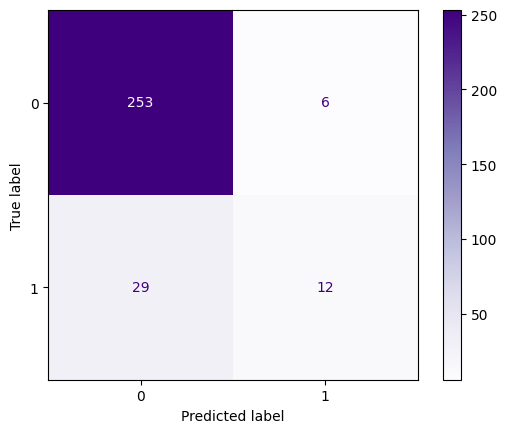

--------------------------------------------------
Accuracy: 0.8833333333333333


In [20]:
model_lgbm = lgb.LGBMClassifier()
model_lgbm, roc_auc_lgbm = model_run_assess(model_lgbm, x_train, y_train, x_test, y_test)

Again, nothing changed much with XGB Classifier or the Cat Boost Classifier

ROC_AUC = 0.6655523118937753
--------------------------------------------------
              precision    recall  f1-score   support

         0.0    0.90580   0.96525   0.93458       259
         1.0    0.62500   0.36585   0.46154        41

    accuracy                        0.88333       300
   macro avg    0.76540   0.66555   0.69806       300
weighted avg    0.86742   0.88333   0.86993       300

--------------------------------------------------


<Figure size 100x100 with 0 Axes>

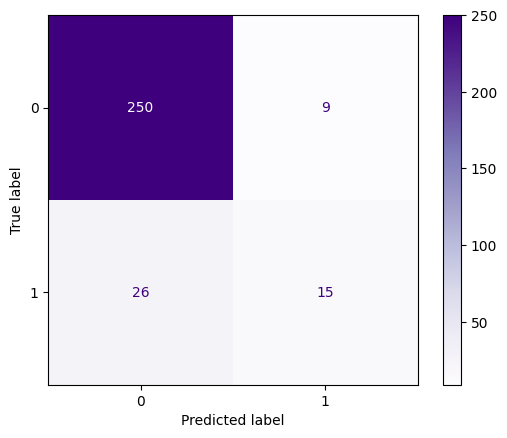

--------------------------------------------------
Accuracy: 0.8833333333333333


In [21]:
model_xgb = xgb.XGBClassifier()
model_xgb, roc_auc_xgb = model_run_assess(model_xgb, x_train, y_train, x_test, y_test)

And also nothing much changed with Cat Boost as well but all models are looking pretty okay except 

ROC_AUC = 0.6405499576231284
--------------------------------------------------
              precision    recall  f1-score   support

         0.0    0.89825   0.98842   0.94118       259
         1.0    0.80000   0.29268   0.42857        41

    accuracy                        0.89333       300
   macro avg    0.84912   0.64055   0.68487       300
weighted avg    0.88482   0.89333   0.87112       300

--------------------------------------------------


<Figure size 100x100 with 0 Axes>

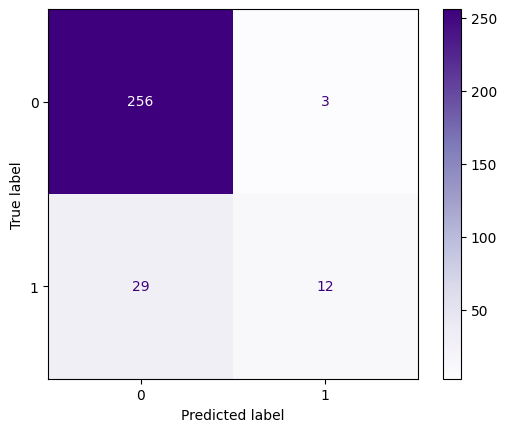

--------------------------------------------------
Accuracy: 0.8933333333333333


In [22]:
model_cbc = CatBoostClassifier(verbose=False)
model_cbc, roc_auc_cbc = model_run_assess(model_cbc, x_train, y_train, x_test, y_test)

# Conclusion

Overall, with an accuracy of 0.91 and all higher precision, recall and F1 scores compared to other models, Gradient Boosting Classifier is the best performing model ✨✨✨✨✨